# Import Libraries

In [1]:
# For drive access
from google.colab import drive
drive.mount('/content/drive')

# Standard libraries
import numpy as np
import pandas as pd

# for loading the pickle files with features and labels
import pickle

# For audio
from IPython.display import Audio
import librosa

# For modeling
import tensorflow as tf
from sklearn.metrics import classification_report

# For visualization
import matplotlib.pyplot as plt
import seaborn as sns

Mounted at /content/drive


# Load features and labels from train and val pickle

In [2]:
with open('/content/drive/MyDrive/Projects/train_val_features_pkl/train_val_8_sec_audio_features_not_avgpooled.pkl', 'rb') as file:
  audio_df = pickle.load(file)

In [3]:
audio_df

{'train': {'mfcc': array([[[0.2926833 , 0.5472208 , 0.51762646, ..., 0.42902297,
           0.5246572 , 0.39747417],
          [0.38219857, 0.63193434, 0.4692648 , ..., 0.4789598 ,
           0.5143834 , 0.35231233],
          [0.4352324 , 0.62795496, 0.4937711 , ..., 0.53823024,
           0.5205363 , 0.36665156],
          ...,
          [0.6295364 , 0.3740691 , 0.4684327 , ..., 0.74904454,
           0.6659465 , 0.13212648],
          [0.6729512 , 0.37194872, 0.47004578, ..., 0.63276273,
           0.6894711 , 0.25973636],
          [0.6984098 , 0.35604227, 0.50428545, ..., 0.49908003,
           0.694181  , 0.40737295]],
  
         [[0.571982  , 0.52721703, 0.35377806, ..., 0.31411108,
           0.45345846, 0.5325761 ],
          [0.57278824, 0.51283437, 0.33133256, ..., 0.44663262,
           0.59104645, 0.5540432 ],
          [0.5442881 , 0.50030595, 0.39622635, ..., 0.4177069 ,
           0.63780564, 0.5152073 ],
          ...,
          [0.65820706, 0.30996823, 0.5541669 , ..

In [4]:
with open('/content/drive/MyDrive/Projects/train_val_features_pkl/train_val_8_sec_non_audio_features.pkl', 'rb') as file:
  non_audio_df = pickle.load(file)

In [5]:
non_audio_df

{'train': {'type': array(['blank', 'blank', 'blank', ..., 'blank', 'blank', 'blank'],
        dtype='<U5'),
  'continent': array(['AFRICA', 'AFRICA', 'AFRICA', ..., 'EUROPE', 'EUROPE', 'EUROPE'],
        dtype='<U8'),
  'rating': array([5., 5., 5., ..., 5., 5., 5.]),
  'label': array([0, 0, 0, ..., 2, 2, 2])},
 'val': {'type': array(['song', 'call', 'call', ..., 'blank', 'call', 'call'], dtype='<U5'),
  'continent': array(['EUROPE', 'EUROPE', 'EUROPE', ..., 'EUROPE', 'EUROPE', 'EUROPE'],
        dtype='<U8'),
  'rating': array([3.5, 5. , 4. , ..., 5. , 3. , 3. ]),
  'label': array([0, 0, 1, ..., 2, 1, 2])}}

## confirm the audio features and non_audio features labels line-up

In [6]:
assert np.array_equal(audio_df['train']['label'], non_audio_df['train']['label'])

In [7]:
assert np.array_equal(audio_df['val']['label'], non_audio_df['val']['label'])

# Shuffle the data

In [8]:
def shuffle_data(audio_features, non_audio_features):
  input_len = len(audio_features['label'])
  input_indices = np.random.permutation(input_len)
  audio_features = {key: np.array([audio_features[key][i] for i in input_indices]) for key in audio_features}
  non_audio_features = {key: np.array([non_audio_features[key][i] for i in input_indices]) for key in non_audio_features}

  return audio_features, non_audio_features

In [9]:
audio_df['train'], non_audio_df['train'] = shuffle_data(audio_df['train'], non_audio_df['train'])

In [10]:
for key in audio_df['train'].keys():
  display(key)
  display(audio_df['train'][key].shape)
  display(audio_df['train'][key][:5])

'mfcc'

(4763, 251, 20)

array([[[0.7560594 , 0.7807275 , 0.6080308 , ..., 0.5358027 ,
         0.6615059 , 0.4652874 ],
        [0.6855659 , 0.7892952 , 0.5327117 , ..., 0.59798187,
         0.6869501 , 0.54247993],
        [0.62103105, 0.77171975, 0.5214831 , ..., 0.6402184 ,
         0.7074006 , 0.5191235 ],
        ...,
        [0.5673673 , 0.72684425, 0.63100356, ..., 0.52962947,
         0.6877974 , 0.5926127 ],
        [0.62097144, 0.7488727 , 0.66585773, ..., 0.5269235 ,
         0.5963494 , 0.46521834],
        [0.7055453 , 0.7498661 , 0.6747315 , ..., 0.49725476,
         0.6540079 , 0.42119804]],

       [[0.8141194 , 0.44003892, 0.59084845, ..., 0.56583095,
         0.33738917, 0.5833463 ],
        [0.7053315 , 0.43398607, 0.56566334, ..., 0.6931965 ,
         0.347004  , 0.7216958 ],
        [0.46506178, 0.48254678, 0.65735316, ..., 0.8857011 ,
         0.18812782, 0.8404185 ],
        ...,
        [0.49391004, 0.69794893, 0.50794613, ..., 0.4525676 ,
         0.6846837 , 0.47540817],
        [0.4

'chroma'

(4763, 251, 12)

array([[[7.01935887e-01, 5.90145946e-01, 6.25872612e-01, ...,
         5.94625890e-01, 5.25810122e-01, 7.10010707e-01],
        [6.04233563e-01, 5.61264753e-01, 7.97000587e-01, ...,
         5.69459856e-01, 4.32322770e-01, 6.02864504e-01],
        [3.51215184e-01, 3.57339650e-01, 3.96457702e-01, ...,
         3.07824910e-01, 3.25832665e-01, 4.24081594e-01],
        ...,
        [6.94082916e-01, 7.03982353e-01, 8.15318644e-01, ...,
         6.38841152e-01, 7.76480794e-01, 7.87384212e-01],
        [8.93737614e-01, 8.05692196e-01, 7.94047475e-01, ...,
         6.72002614e-01, 7.78232872e-01, 8.52373362e-01],
        [1.00000012e+00, 9.58088875e-01, 8.69235456e-01, ...,
         8.45969796e-01, 9.35349405e-01, 9.81173992e-01]],

       [[3.10807675e-03, 2.09971398e-01, 1.00000000e+00, ...,
         5.67366718e-04, 2.31843675e-04, 7.14490365e-04],
        [5.90467826e-04, 1.17422648e-01, 1.00000000e+00, ...,
         1.53998597e-04, 2.36323467e-05, 6.81333477e-05],
        [4.89105769e-05, 

'rms'

(4763, 251, 1)

array([[[0.12614377],
        [0.14077388],
        [0.15006046],
        ...,
        [0.13940501],
        [0.12803099],
        [0.10592128]],

       [[0.47416025],
        [0.5525639 ],
        [0.5852842 ],
        ...,
        [0.00257983],
        [0.00241488],
        [0.00202891]],

       [[0.01719951],
        [0.01864685],
        [0.01873469],
        ...,
        [0.01999445],
        [0.01868733],
        [0.01621514]],

       [[0.10767362],
        [0.11958715],
        [0.12007345],
        ...,
        [0.04635619],
        [0.04142246],
        [0.03205635]],

       [[0.07098757],
        [0.06749916],
        [0.06573243],
        ...,
        [0.05964915],
        [0.05974501],
        [0.05385572]]], dtype=float32)

'spectral_centroid'

(4763, 251, 1)

array([[[0.11556656],
        [0.08329378],
        [0.07146501],
        ...,
        [0.07564075],
        [0.08961779],
        [0.12061074]],

       [[0.664023  ],
        [0.67558388],
        [0.71113523],
        ...,
        [0.27601098],
        [0.27144151],
        [0.258076  ]],

       [[0.30692932],
        [0.2983247 ],
        [0.3075286 ],
        ...,
        [0.27577193],
        [0.25099364],
        [0.23390553]],

       [[0.32263304],
        [0.31456789],
        [0.31881484],
        ...,
        [0.27632405],
        [0.28917986],
        [0.28992148]],

       [[0.19100858],
        [0.21446895],
        [0.24720471],
        ...,
        [0.38614677],
        [0.39123864],
        [0.33807032]]])

'melspectrogram'

(4763, 251, 20)

array([[[0.79990405, 0.7697251 , 0.73402715, ..., 0.46553114,
         0.46269795, 0.48592684],
        [0.76033807, 0.73837   , 0.70756716, ..., 0.39070025,
         0.38702947, 0.39200506],
        [0.74732393, 0.72110045, 0.6839598 , ..., 0.33966967,
         0.3259272 , 0.33487725],
        ...,
        [0.8070798 , 0.66974175, 0.6507696 , ..., 0.41123044,
         0.33136284, 0.30284315],
        [0.80127627, 0.6769152 , 0.659171  , ..., 0.39464894,
         0.39094266, 0.3789632 ],
        [0.83133364, 0.72228926, 0.6907681 , ..., 0.43880787,
         0.47489718, 0.45550355]],

       [[0.60785735, 0.6173519 , 0.6092406 , ..., 0.9396205 ,
         0.6551287 , 0.6787683 ],
        [0.5512733 , 0.53582954, 0.5377618 , ..., 0.94912845,
         0.5721283 , 0.6343055 ],
        [0.4797933 , 0.45899898, 0.4337583 , ..., 0.9919296 ,
         0.354723  , 0.5726332 ],
        ...,
        [0.54818505, 0.5203103 , 0.52255   , ..., 0.28583872,
         0.2995652 , 0.2791531 ],
        [0.5

'label'

(4763,)

array([2, 1, 0, 0, 1])

In [11]:
for key in non_audio_df['train'].keys():
  display(key)
  display(non_audio_df['train'][key].shape)
  display(non_audio_df['train'][key][:5])

'type'

(4763,)

array(['call', 'call', 'call', 'call', 'call'], dtype='<U5')

'continent'

(4763,)

array(['EUROPE', 'EUROPE', 'EUROPE', 'EUROPE', 'EUROPE'], dtype='<U8')

'rating'

(4763,)

array([2.5, 4.5, 4.5, 4.5, 4. ])

'label'

(4763,)

array([2, 1, 0, 0, 1])

In [12]:
audio_df['val'], non_audio_df['val'] = shuffle_data(audio_df['val'], non_audio_df['val'])

In [13]:
for key in audio_df['val'].keys():
  display(key)
  display(audio_df['val'][key].shape)
  display(audio_df['val'][key][:5])

'mfcc'

(2430, 251, 20)

array([[[ 6.0767198e-01,  3.3929217e-01,  1.2638870e-01, ...,
          4.3000379e-01,  3.2214761e-01,  4.2442816e-01],
        [ 5.9667611e-01,  3.4334332e-01,  1.4080182e-01, ...,
          5.3104162e-01,  3.9776695e-01,  4.2801473e-01],
        [ 5.7412648e-01,  3.4884414e-01,  2.1199119e-01, ...,
          6.1102760e-01,  4.7137809e-01,  4.3522665e-01],
        ...,
        [ 5.0730097e-01,  4.2869285e-01,  2.8908971e-01, ...,
          2.5697890e-01,  5.8772230e-01,  3.9382550e-01],
        [ 5.1483035e-01,  4.6503460e-01,  2.3680347e-01, ...,
          2.3870106e-01,  5.0428826e-01,  4.3505341e-01],
        [ 5.3174317e-01,  4.9210283e-01,  2.6860937e-01, ...,
          2.5102550e-01,  5.8419842e-01,  4.8901543e-01]],

       [[ 7.3712224e-01,  9.4621408e-01,  5.0062132e-01, ...,
          4.8126590e-01,  5.8853155e-01,  6.0286939e-01],
        [ 7.3515534e-01,  9.3542039e-01,  4.5336026e-01, ...,
          5.9374583e-01,  6.2728971e-01,  5.6532663e-01],
        [ 7.0249724e-01, 

'chroma'

(2430, 251, 12)

array([[[0.41460457, 0.60159624, 1.        , ..., 0.22798465,
         0.20613906, 0.29679275],
        [0.61759055, 0.440444  , 1.        , ..., 0.5274253 ,
         0.3984083 , 0.6749524 ],
        [0.24814928, 0.19848399, 0.40767834, ..., 0.7472339 ,
         0.2754166 , 0.24902773],
        ...,
        [0.85649055, 0.44154957, 0.20199329, ..., 0.10402797,
         0.37448508, 1.        ],
        [0.25783008, 0.10461716, 0.13535066, ..., 0.18967552,
         1.0000001 , 0.97097814],
        [0.06767145, 0.03772625, 0.09775172, ..., 0.2531087 ,
         1.        , 0.46437985]],

       [[1.        , 0.9819837 , 0.79838324, ..., 0.7596702 ,
         0.72284657, 0.95698047],
        [0.7010292 , 0.7708866 , 0.79841655, ..., 0.9242673 ,
         0.74634135, 0.7989668 ],
        [0.5341497 , 0.6887657 , 1.        , ..., 0.7166055 ,
         0.6769224 , 0.5638939 ],
        ...,
        [1.        , 0.74184406, 0.5777666 , ..., 0.4147998 ,
         0.45521268, 0.69573236],
        [0.8

'rms'

(2430, 251, 1)

array([[[0.01097545],
        [0.01201979],
        [0.01320398],
        ...,
        [0.00809848],
        [0.00786287],
        [0.00663631]],

       [[0.07730355],
        [0.0848301 ],
        [0.08810724],
        ...,
        [0.0827369 ],
        [0.0736937 ],
        [0.05468333]],

       [[0.01768884],
        [0.01936383],
        [0.02022451],
        ...,
        [0.01857591],
        [0.01637497],
        [0.01442058]],

       [[0.07619725],
        [0.08053334],
        [0.08508856],
        ...,
        [0.0063166 ],
        [0.00649125],
        [0.00631574]],

       [[0.00270467],
        [0.00308526],
        [0.00356347],
        ...,
        [0.03025477],
        [0.0319837 ],
        [0.02949382]]], dtype=float32)

'spectral_centroid'

(2430, 251, 1)

array([[[0.51560702],
        [0.49817313],
        [0.49414929],
        ...,
        [0.48230286],
        [0.46349262],
        [0.43575708]],

       [[0.07208578],
        [0.07667212],
        [0.08801261],
        ...,
        [0.07870747],
        [0.07633675],
        [0.07070482]],

       [[0.31096103],
        [0.31537617],
        [0.32154216],
        ...,
        [0.33372236],
        [0.33656345],
        [0.31332071]],

       [[0.619543  ],
        [0.61364492],
        [0.63281573],
        ...,
        [0.48275141],
        [0.490506  ],
        [0.48863557]],

       [[0.3854478 ],
        [0.4367422 ],
        [0.50993119],
        ...,
        [0.50604982],
        [0.52695438],
        [0.52921128]]])

'melspectrogram'

(2430, 251, 20)

array([[[0.22864807, 0.18508822, 0.3569706 , ..., 0.58277345,
         0.46733907, 0.42124516],
        [0.20558333, 0.10767043, 0.3674301 , ..., 0.5578374 ,
         0.46417627, 0.40672398],
        [0.20470595, 0.1343661 , 0.37355086, ..., 0.5260457 ,
         0.47865447, 0.44219086],
        ...,
        [0.22235423, 0.12133998, 0.41213563, ..., 0.4634667 ,
         0.41054258, 0.3119374 ],
        [0.27343965, 0.2283094 , 0.39035568, ..., 0.42955533,
         0.37749097, 0.30962837],
        [0.3512397 , 0.3004598 , 0.36651096, ..., 0.40337723,
         0.36781073, 0.3076372 ]],

       [[0.8195387 , 0.79450256, 0.80417687, ..., 0.34838715,
         0.34947786, 0.3701117 ],
        [0.81093204, 0.7882941 , 0.8114716 , ..., 0.3328074 ,
         0.33632496, 0.3350467 ],
        [0.7988956 , 0.8068593 , 0.78936625, ..., 0.34299546,
         0.33077714, 0.34267133],
        ...,
        [0.87435013, 0.80928445, 0.83396685, ..., 0.3242513 ,
         0.32961816, 0.31812274],
        [0.8

'label'

(2430,)

array([2, 1, 0, 0, 0])

In [14]:
for key in non_audio_df['val'].keys():
  display(key)
  display(non_audio_df['val'][key].shape)
  display(non_audio_df['val'][key][:5])

'type'

(2430,)

array(['call', 'call', 'call', 'both', 'call'], dtype='<U5')

'continent'

(2430,)

array(['EUROPE', 'EUROPE', 'EUROPE', 'EUROPE', 'AMERICAS'], dtype='<U8')

'rating'

(2430,)

array([3.5, 5. , 3. , 3. , 4.5])

'label'

(2430,)

array([2, 1, 0, 0, 0])

# Create sample weights based on rating

In [15]:
training_sample_weights = non_audio_df['train']['rating']

training_sample_weights

array([2.5, 4.5, 4.5, ..., 4. , 4. , 3. ])

In [16]:
validation_sample_weights = non_audio_df['val']['rating']

validation_sample_weights

array([3.5, 5. , 3. , ..., 4. , 3. , 5. ])

In [17]:
training_sample_weights = np.where(training_sample_weights > 3.0, 0.6, 0.4)

training_sample_weights

array([0.4, 0.6, 0.6, ..., 0.6, 0.6, 0.4])

In [18]:
validation_sample_weights = np.where(validation_sample_weights > 3.0, 0.6, 0.4)

validation_sample_weights

array([0.6, 0.6, 0.4, ..., 0.6, 0.4, 0.6])

# GRU Models

In [19]:
train_results = {}
val_results = {}

In [20]:
classes = ['barswa', 'comsan', 'eaywag1']

## Create GRU model function

In [21]:
def build_model(audio_features,
                learning_rate=0.002,
                gru=256,
                hidden=[256,128,48],
                dropout=0.3):

  tf.keras.backend.clear_session()

  # set audio features input layer
  audio_features = tf.keras.layers.Input(shape=(audio_features.shape[1],audio_features.shape[2]), name='Audio_Features')

  # add sequential model
  model = tf.keras.models.Sequential()
  model.add(tf.keras.layers.GRU(gru, input_shape=(audio_features.shape[1],audio_features.shape[2])))
  model.add(tf.keras.layers.BatchNormalization())
  model.add(tf.keras.layers.Dropout(dropout))

  for size in hidden:
    model.add(tf.keras.layers.Dense(size, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)))
    model.add(tf.keras.layers.Dropout(dropout))

  model.add(tf.keras.layers.Dense(units=3,activation='softmax'))

  print(model.summary())

  # compile model
  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'],
              weighted_metrics=['accuracy'])

  return model

In [22]:
def visualize(model_history, best_epoch):
  fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
  # visualize the loss
  axes[0].plot(model_history.history['loss'][:best_epoch+1], color='purple', label='train_losses')
  axes[0].plot(model_history.history['val_loss'][:best_epoch+1], color='orange', label='val_losses')
  axes[0].set_xlabel('Epoch')
  axes[0].set_ylabel('Loss')
  axes[0].set_title('Loss Progression')
  axes[0].legend()

  # visualze the accuracy
  axes[1].plot(model_history.history['accuracy'][:best_epoch+1], color='purple', label='train_accuracy')
  axes[1].plot(model_history.history['val_accuracy'][:best_epoch+1], color='orange', label='val_accuracy')
  axes[1].set_xlabel('Epoch')
  axes[1].set_ylabel('Accuracy')
  axes[1].set_title('Accuracy Progression')
  axes[1].legend()

  plt.show()

## With mfcc & chroma

### create features

In [23]:
training_audio_features = np.concatenate((audio_df['train']['mfcc'], audio_df['train']['chroma']), axis=-1)

training_audio_features

array([[[7.5605941e-01, 7.8072751e-01, 6.0803080e-01, ...,
         5.9462589e-01, 5.2581012e-01, 7.1001071e-01],
        [6.8556589e-01, 7.8929520e-01, 5.3271168e-01, ...,
         5.6945986e-01, 4.3232277e-01, 6.0286450e-01],
        [6.2103105e-01, 7.7171975e-01, 5.2148312e-01, ...,
         3.0782491e-01, 3.2583266e-01, 4.2408159e-01],
        ...,
        [5.6736732e-01, 7.2684425e-01, 6.3100356e-01, ...,
         6.3884115e-01, 7.7648079e-01, 7.8738421e-01],
        [6.2097144e-01, 7.4887270e-01, 6.6585773e-01, ...,
         6.7200261e-01, 7.7823287e-01, 8.5237336e-01],
        [7.0554531e-01, 7.4986613e-01, 6.7473149e-01, ...,
         8.4596980e-01, 9.3534940e-01, 9.8117399e-01]],

       [[8.1411940e-01, 4.4003892e-01, 5.9084845e-01, ...,
         5.6736672e-04, 2.3184367e-04, 7.1449036e-04],
        [7.0533150e-01, 4.3398607e-01, 5.6566334e-01, ...,
         1.5399860e-04, 2.3632347e-05, 6.8133348e-05],
        [4.6506178e-01, 4.8254678e-01, 6.5735316e-01, ...,
         2.567

In [24]:
training_audio_features.shape

(4763, 251, 32)

In [25]:
validation_audio_features = np.concatenate((audio_df['val']['mfcc'], audio_df['val']['chroma']), axis=-1)

validation_audio_features

array([[[ 6.0767198e-01,  3.3929217e-01,  1.2638870e-01, ...,
          2.2798465e-01,  2.0613906e-01,  2.9679275e-01],
        [ 5.9667611e-01,  3.4334332e-01,  1.4080182e-01, ...,
          5.2742529e-01,  3.9840829e-01,  6.7495239e-01],
        [ 5.7412648e-01,  3.4884414e-01,  2.1199119e-01, ...,
          7.4723393e-01,  2.7541661e-01,  2.4902773e-01],
        ...,
        [ 5.0730097e-01,  4.2869285e-01,  2.8908971e-01, ...,
          1.0402797e-01,  3.7448508e-01,  1.0000000e+00],
        [ 5.1483035e-01,  4.6503460e-01,  2.3680347e-01, ...,
          1.8967552e-01,  1.0000001e+00,  9.7097814e-01],
        [ 5.3174317e-01,  4.9210283e-01,  2.6860937e-01, ...,
          2.5310871e-01,  1.0000000e+00,  4.6437985e-01]],

       [[ 7.3712224e-01,  9.4621408e-01,  5.0062132e-01, ...,
          7.5967020e-01,  7.2284657e-01,  9.5698047e-01],
        [ 7.3515534e-01,  9.3542039e-01,  4.5336026e-01, ...,
          9.2426729e-01,  7.4634135e-01,  7.9896683e-01],
        [ 7.0249724e-01, 

In [26]:
validation_audio_features.shape

(2430, 251, 32)

### fit the model with training data

In [27]:
callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_weighted_accuracy",
    patience=20,
    restore_best_weights=True,
    start_from_epoch=50,
)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 256)               222720    
                                                                 
 batch_normalization (Batch  (None, 256)               1024      
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense (Dense)               (None, 256)               65792     
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                        

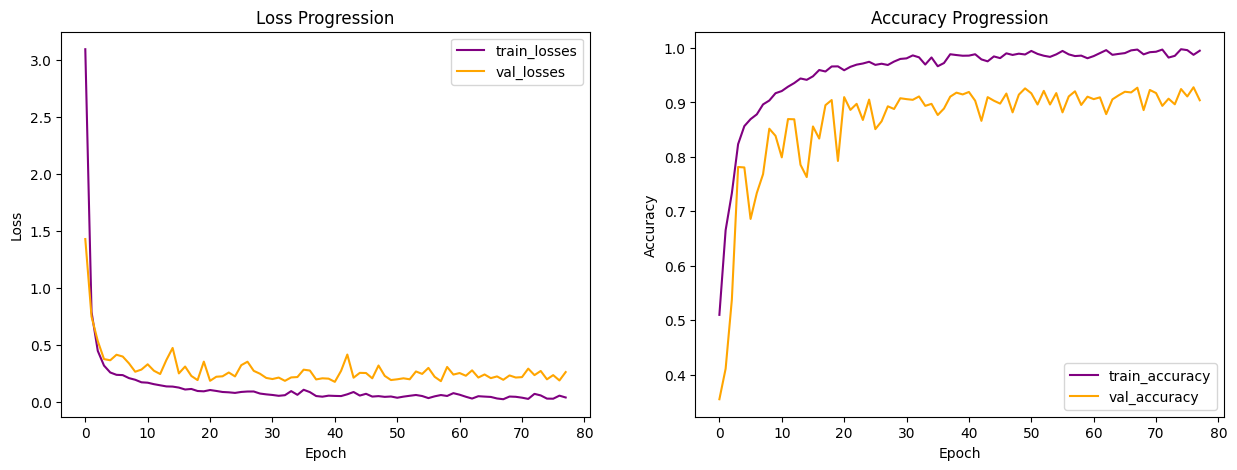

In [28]:
model = build_model(training_audio_features,
                    learning_rate=0.002,
                    gru=256,
                    hidden=[256,128,48],
                    dropout=0.3)

history = model.fit(
   x=training_audio_features,
   y=audio_df['train']['label'],
   sample_weight=training_sample_weights,
   epochs=100,
   validation_data=(
      validation_audio_features,
      audio_df['val']['label'],
      validation_sample_weights
   ),
   batch_size=64,
   callbacks=[callback],
   verbose=1)

best_epoch = history.history['val_weighted_accuracy'].index(max(history.history['val_weighted_accuracy']))+1
print('best_epoch: ', best_epoch)

visualize(history, best_epoch)

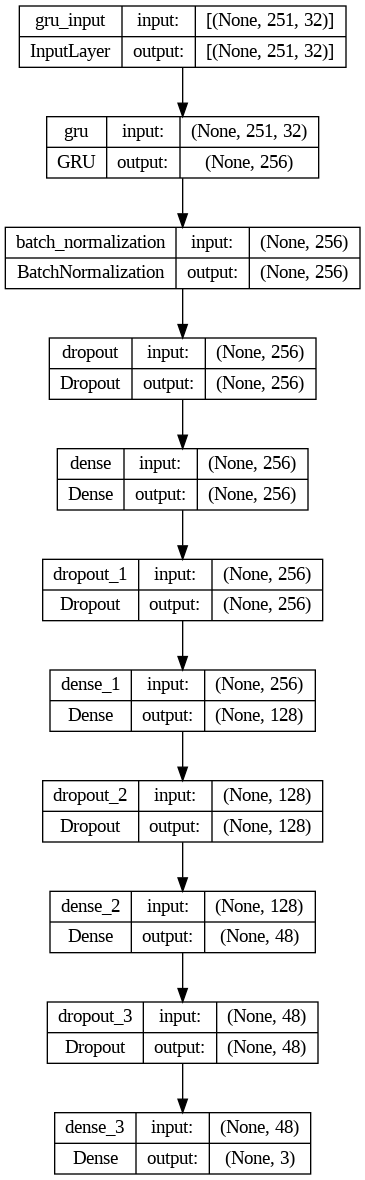

In [29]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [30]:
train_yhat = model.predict(training_audio_features)

train_yhat_result = np.argmax(train_yhat, axis=-1)

train_results['mfcc_chroma'] = model.evaluate(training_audio_features,
                                                         audio_df['train']['label'])[-1]

149/149 [==============================] - 2s 8ms/step - loss: 0.0500 - accuracy: 0.9962 - weighted_accuracy: 0.9962


In [31]:
val_yhat = model.predict(validation_audio_features)

val_yhat_result = np.argmax(val_yhat, axis=-1)

val_results['mfcc_chroma'] = model.evaluate(validation_audio_features,
                                                         audio_df['val']['label'])[-1]

76/76 [==============================] - 1s 7ms/step - loss: 0.3355 - accuracy: 0.9280 - weighted_accuracy: 0.9280


### evaluate the results

In [32]:
print('Training classification Report \n')
print(classification_report(audio_df['train']['label'], train_yhat_result, target_names=classes))

Training classification Report 

              precision    recall  f1-score   support

      barswa       1.00      1.00      1.00      1603
      comsan       1.00      0.99      1.00      1578
     eaywag1       0.99      1.00      1.00      1582

    accuracy                           1.00      4763
   macro avg       1.00      1.00      1.00      4763
weighted avg       1.00      1.00      1.00      4763



In [33]:
print('Validation classification Report \n')
print(classification_report(audio_df['val']['label'], val_yhat_result, target_names=classes))

Validation classification Report 

              precision    recall  f1-score   support

      barswa       0.94      0.92      0.93      1032
      comsan       0.89      0.93      0.91       618
     eaywag1       0.94      0.94      0.94       780

    accuracy                           0.93      2430
   macro avg       0.92      0.93      0.93      2430
weighted avg       0.93      0.93      0.93      2430



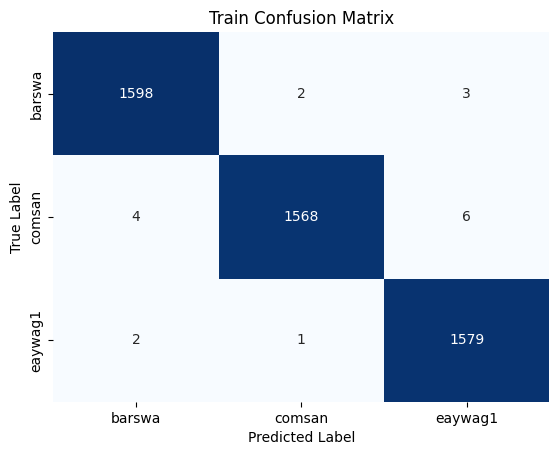

In [34]:
train_cm = tf.math.confusion_matrix(audio_df['train']['label'], train_yhat_result)

ax = sns.heatmap(train_cm,
                 annot=True,
                 fmt='.0f',
                 cmap='Blues',
                 xticklabels=classes,
                 yticklabels=classes,
                 cbar=False)

ax.set(xlabel='Predicted Label', ylabel='True Label')
plt.title('Train Confusion Matrix')
plt.show()

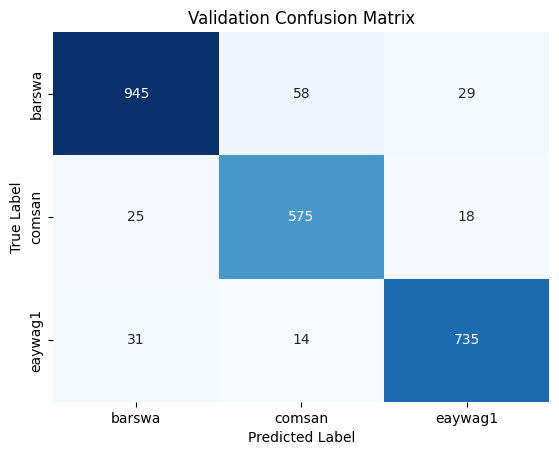

In [35]:
val_cm = tf.math.confusion_matrix(audio_df['val']['label'], val_yhat_result)

ax = sns.heatmap(val_cm,
                 annot=True,
                 fmt='.0f',
                 cmap='Blues',
                 xticklabels=classes,
                 yticklabels=classes,
                 cbar=False)

ax.set(xlabel='Predicted Label', ylabel='True Label')
plt.title('Validation Confusion Matrix')
plt.show()

## With mfcc & rms

### create features

In [36]:
training_audio_features = np.concatenate((audio_df['train']['mfcc'], audio_df['train']['rms']), axis=-1)

training_audio_features

array([[[0.7560594 , 0.7807275 , 0.6080308 , ..., 0.6615059 ,
         0.4652874 , 0.12614377],
        [0.6855659 , 0.7892952 , 0.5327117 , ..., 0.6869501 ,
         0.54247993, 0.14077388],
        [0.62103105, 0.77171975, 0.5214831 , ..., 0.7074006 ,
         0.5191235 , 0.15006046],
        ...,
        [0.5673673 , 0.72684425, 0.63100356, ..., 0.6877974 ,
         0.5926127 , 0.13940501],
        [0.62097144, 0.7488727 , 0.66585773, ..., 0.5963494 ,
         0.46521834, 0.12803099],
        [0.7055453 , 0.7498661 , 0.6747315 , ..., 0.6540079 ,
         0.42119804, 0.10592128]],

       [[0.8141194 , 0.44003892, 0.59084845, ..., 0.33738917,
         0.5833463 , 0.47416025],
        [0.7053315 , 0.43398607, 0.56566334, ..., 0.347004  ,
         0.7216958 , 0.5525639 ],
        [0.46506178, 0.48254678, 0.65735316, ..., 0.18812782,
         0.8404185 , 0.5852842 ],
        ...,
        [0.49391004, 0.69794893, 0.50794613, ..., 0.6846837 ,
         0.47540817, 0.00257983],
        [0.4

In [37]:
training_audio_features.shape

(4763, 251, 21)

In [38]:
validation_audio_features = np.concatenate((audio_df['val']['mfcc'], audio_df['val']['rms']), axis=-1)

validation_audio_features

array([[[ 6.07671976e-01,  3.39292169e-01,  1.26388699e-01, ...,
          3.22147608e-01,  4.24428165e-01,  1.09754484e-02],
        [ 5.96676111e-01,  3.43343318e-01,  1.40801817e-01, ...,
          3.97766948e-01,  4.28014725e-01,  1.20197879e-02],
        [ 5.74126482e-01,  3.48844141e-01,  2.11991191e-01, ...,
          4.71378088e-01,  4.35226649e-01,  1.32039785e-02],
        ...,
        [ 5.07300973e-01,  4.28692847e-01,  2.89089710e-01, ...,
          5.87722301e-01,  3.93825501e-01,  8.09847936e-03],
        [ 5.14830351e-01,  4.65034604e-01,  2.36803472e-01, ...,
          5.04288256e-01,  4.35053408e-01,  7.86286686e-03],
        [ 5.31743169e-01,  4.92102832e-01,  2.68609375e-01, ...,
          5.84198415e-01,  4.89015430e-01,  6.63630804e-03]],

       [[ 7.37122238e-01,  9.46214080e-01,  5.00621319e-01, ...,
          5.88531554e-01,  6.02869391e-01,  7.73035511e-02],
        [ 7.35155344e-01,  9.35420394e-01,  4.53360260e-01, ...,
          6.27289712e-01,  5.65326631e

In [39]:
validation_audio_features.shape

(2430, 251, 21)

### fit the model with training data

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 256)               214272    
                                                                 
 batch_normalization (Batch  (None, 256)               1024      
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense (Dense)               (None, 256)               65792     
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                        

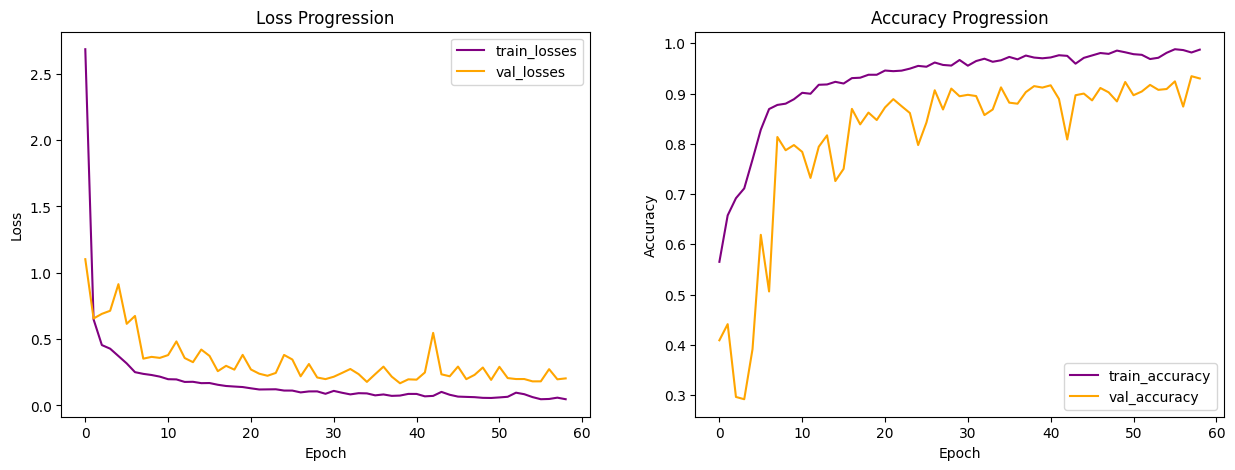

In [40]:
model = build_model(training_audio_features,
                    learning_rate=0.002,
                    gru=256,
                    hidden=[256,128,48],
                    dropout=0.3)

history = model.fit(
   x=training_audio_features,
   y=audio_df['train']['label'],
   sample_weight=training_sample_weights,
   epochs=100,
   validation_data=(
      validation_audio_features,
      audio_df['val']['label'],
      validation_sample_weights
   ),
   batch_size=64,
   callbacks=[callback],
   verbose=1)

best_epoch = history.history['val_weighted_accuracy'].index(max(history.history['val_weighted_accuracy']))+1
print('best_epoch: ', best_epoch)

visualize(history, best_epoch)

In [41]:
train_yhat = model.predict(training_audio_features)

train_yhat_result = np.argmax(train_yhat, axis=-1)

train_results['mfcc_rms'] = model.evaluate(training_audio_features,
                                                         audio_df['train']['label'])[-1]

149/149 [==============================] - 2s 7ms/step - loss: 0.0553 - accuracy: 0.9933 - weighted_accuracy: 0.9933


In [42]:
val_yhat = model.predict(validation_audio_features)

val_yhat_result = np.argmax(val_yhat, axis=-1)

val_results['mfcc_rms'] = model.evaluate(validation_audio_features,
                                                         audio_df['val']['label'])[-1]

76/76 [==============================] - 1s 7ms/step - loss: 0.3426 - accuracy: 0.9346 - weighted_accuracy: 0.9346


### evaluate the results

In [43]:
print('Training classification Report \n')
print(classification_report(audio_df['train']['label'], train_yhat_result, target_names=classes))

Training classification Report 

              precision    recall  f1-score   support

      barswa       0.99      0.99      0.99      1603
      comsan       1.00      0.99      0.99      1578
     eaywag1       0.99      1.00      0.99      1582

    accuracy                           0.99      4763
   macro avg       0.99      0.99      0.99      4763
weighted avg       0.99      0.99      0.99      4763



In [44]:
print('Validation classification Report \n')
print(classification_report(audio_df['val']['label'], val_yhat_result, target_names=classes))

Validation classification Report 

              precision    recall  f1-score   support

      barswa       0.94      0.93      0.93      1032
      comsan       0.91      0.93      0.92       618
     eaywag1       0.95      0.95      0.95       780

    accuracy                           0.93      2430
   macro avg       0.93      0.94      0.93      2430
weighted avg       0.93      0.93      0.93      2430



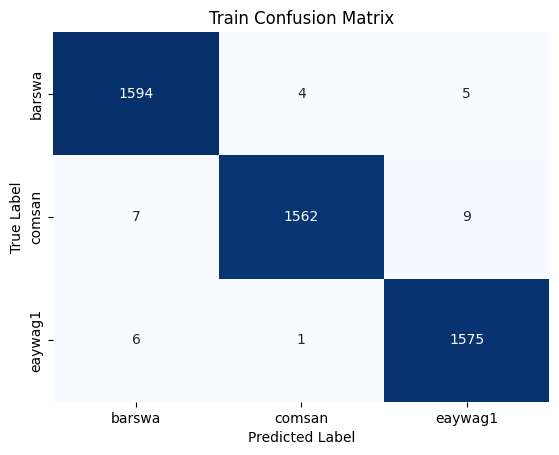

In [45]:
train_cm = tf.math.confusion_matrix(audio_df['train']['label'], train_yhat_result)

ax = sns.heatmap(train_cm,
                 annot=True,
                 fmt='.0f',
                 cmap='Blues',
                 xticklabels=classes,
                 yticklabels=classes,
                 cbar=False)

ax.set(xlabel='Predicted Label', ylabel='True Label')
plt.title('Train Confusion Matrix')
plt.show()

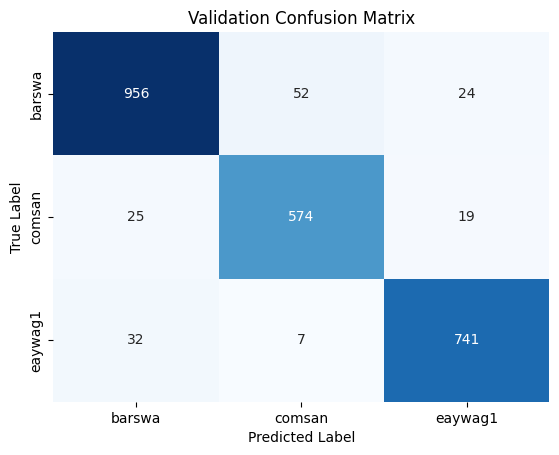

In [46]:
val_cm = tf.math.confusion_matrix(audio_df['val']['label'], val_yhat_result)

ax = sns.heatmap(val_cm,
                 annot=True,
                 fmt='.0f',
                 cmap='Blues',
                 xticklabels=classes,
                 yticklabels=classes,
                 cbar=False)

ax.set(xlabel='Predicted Label', ylabel='True Label')
plt.title('Validation Confusion Matrix')
plt.show()

## With mfcc & spectral_centroid

### create features

In [47]:
training_audio_features = np.concatenate((audio_df['train']['mfcc'], audio_df['train']['spectral_centroid']), axis=-1)

training_audio_features

array([[[0.75605941, 0.78072751, 0.6080308 , ..., 0.66150588,
         0.46528739, 0.11556656],
        [0.68556589, 0.7892952 , 0.53271168, ..., 0.68695009,
         0.54247993, 0.08329378],
        [0.62103105, 0.77171975, 0.52148312, ..., 0.70740062,
         0.51912349, 0.07146501],
        ...,
        [0.56736732, 0.72684425, 0.63100356, ..., 0.68779743,
         0.59261268, 0.07564075],
        [0.62097144, 0.7488727 , 0.66585773, ..., 0.59634942,
         0.46521834, 0.08961779],
        [0.70554531, 0.74986613, 0.67473149, ..., 0.65400791,
         0.42119804, 0.12061074]],

       [[0.8141194 , 0.44003892, 0.59084845, ..., 0.33738917,
         0.58334631, 0.664023  ],
        [0.7053315 , 0.43398607, 0.56566334, ..., 0.347004  ,
         0.72169578, 0.67558388],
        [0.46506178, 0.48254678, 0.65735316, ..., 0.18812782,
         0.84041852, 0.71113523],
        ...,
        [0.49391004, 0.69794893, 0.50794613, ..., 0.68468368,
         0.47540817, 0.27601098],
        [0.4

In [48]:
training_audio_features.shape

(4763, 251, 21)

In [49]:
validation_audio_features = np.concatenate((audio_df['val']['mfcc'], audio_df['val']['spectral_centroid']), axis=-1)

validation_audio_features

array([[[ 6.07671976e-01,  3.39292169e-01,  1.26388699e-01, ...,
          3.22147608e-01,  4.24428165e-01,  5.15607021e-01],
        [ 5.96676111e-01,  3.43343318e-01,  1.40801817e-01, ...,
          3.97766948e-01,  4.28014725e-01,  4.98173125e-01],
        [ 5.74126482e-01,  3.48844141e-01,  2.11991191e-01, ...,
          4.71378088e-01,  4.35226649e-01,  4.94149287e-01],
        ...,
        [ 5.07300973e-01,  4.28692847e-01,  2.89089710e-01, ...,
          5.87722301e-01,  3.93825501e-01,  4.82302859e-01],
        [ 5.14830351e-01,  4.65034604e-01,  2.36803472e-01, ...,
          5.04288256e-01,  4.35053408e-01,  4.63492619e-01],
        [ 5.31743169e-01,  4.92102832e-01,  2.68609375e-01, ...,
          5.84198415e-01,  4.89015430e-01,  4.35757079e-01]],

       [[ 7.37122238e-01,  9.46214080e-01,  5.00621319e-01, ...,
          5.88531554e-01,  6.02869391e-01,  7.20857847e-02],
        [ 7.35155344e-01,  9.35420394e-01,  4.53360260e-01, ...,
          6.27289712e-01,  5.65326631e

In [50]:
validation_audio_features.shape

(2430, 251, 21)

### fit the model with training data

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 256)               214272    
                                                                 
 batch_normalization (Batch  (None, 256)               1024      
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense (Dense)               (None, 256)               65792     
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                        

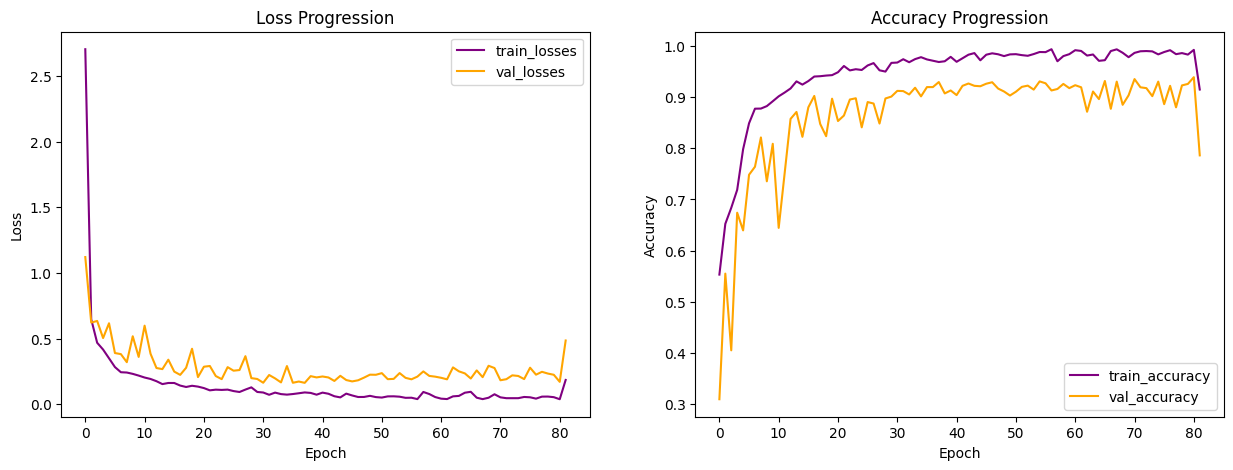

In [51]:
model = build_model(training_audio_features,
                    learning_rate=0.002,
                    gru=256,
                    hidden=[256,128,48],
                    dropout=0.3)

history = model.fit(
   x=training_audio_features,
   y=audio_df['train']['label'],
   sample_weight=training_sample_weights,
   epochs=100,
   validation_data=(
      validation_audio_features,
      audio_df['val']['label'],
      validation_sample_weights
   ),
   batch_size=64,
   callbacks=[callback],
   verbose=1)

best_epoch = history.history['val_weighted_accuracy'].index(max(history.history['val_weighted_accuracy']))+1
print('best_epoch: ', best_epoch)

visualize(history, best_epoch)

In [52]:
train_yhat = model.predict(training_audio_features)

train_yhat_result = np.argmax(train_yhat, axis=-1)

train_results['mfcc_spectral_centroid'] = model.evaluate(training_audio_features,
                                                         audio_df['train']['label'])[-1]

149/149 [==============================] - 2s 8ms/step - loss: 0.0849 - accuracy: 0.9822 - weighted_accuracy: 0.9822


In [53]:
val_yhat = model.predict(validation_audio_features)

val_yhat_result = np.argmax(val_yhat, axis=-1)

val_results['mfcc_spectral_centroid'] = model.evaluate(validation_audio_features,
                                                         audio_df['val']['label'])[-1]

76/76 [==============================] - 1s 7ms/step - loss: 0.4655 - accuracy: 0.9058 - weighted_accuracy: 0.9058


### evaluate the results

In [54]:
print('Training classification Report \n')
print(classification_report(audio_df['train']['label'], train_yhat_result, target_names=classes))

Training classification Report 

              precision    recall  f1-score   support

      barswa       0.99      0.96      0.98      1603
      comsan       0.96      1.00      0.98      1578
     eaywag1       1.00      0.99      0.99      1582

    accuracy                           0.98      4763
   macro avg       0.98      0.98      0.98      4763
weighted avg       0.98      0.98      0.98      4763



In [55]:
print('Validation classification Report \n')
print(classification_report(audio_df['val']['label'], val_yhat_result, target_names=classes))

Validation classification Report 

              precision    recall  f1-score   support

      barswa       0.96      0.85      0.90      1032
      comsan       0.78      0.97      0.86       618
     eaywag1       0.96      0.93      0.95       780

    accuracy                           0.91      2430
   macro avg       0.90      0.92      0.90      2430
weighted avg       0.92      0.91      0.91      2430



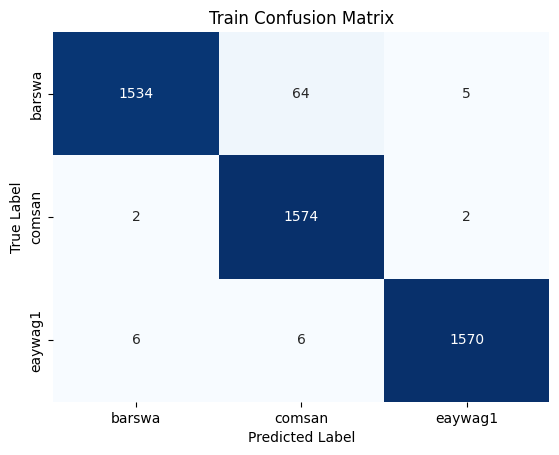

In [56]:
train_cm = tf.math.confusion_matrix(audio_df['train']['label'], train_yhat_result)

ax = sns.heatmap(train_cm,
                 annot=True,
                 fmt='.0f',
                 cmap='Blues',
                 xticklabels=classes,
                 yticklabels=classes,
                 cbar=False)

ax.set(xlabel='Predicted Label', ylabel='True Label')
plt.title('Train Confusion Matrix')
plt.show()

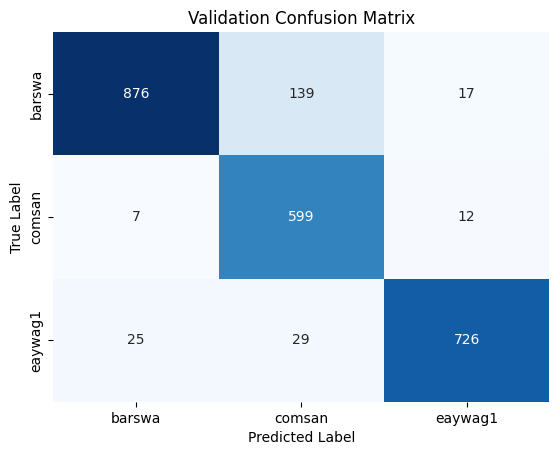

In [57]:
val_cm = tf.math.confusion_matrix(audio_df['val']['label'], val_yhat_result)

ax = sns.heatmap(val_cm,
                 annot=True,
                 fmt='.0f',
                 cmap='Blues',
                 xticklabels=classes,
                 yticklabels=classes,
                 cbar=False)

ax.set(xlabel='Predicted Label', ylabel='True Label')
plt.title('Validation Confusion Matrix')
plt.show()

## With mfcc & rms & spectral_centroid

### create features

In [58]:
training_audio_features = np.concatenate((audio_df['train']['mfcc'], audio_df['train']['rms'], audio_df['train']['spectral_centroid']), axis=-1)

training_audio_features

array([[[0.75605941, 0.78072751, 0.6080308 , ..., 0.46528739,
         0.12614377, 0.11556656],
        [0.68556589, 0.7892952 , 0.53271168, ..., 0.54247993,
         0.14077388, 0.08329378],
        [0.62103105, 0.77171975, 0.52148312, ..., 0.51912349,
         0.15006046, 0.07146501],
        ...,
        [0.56736732, 0.72684425, 0.63100356, ..., 0.59261268,
         0.13940501, 0.07564075],
        [0.62097144, 0.7488727 , 0.66585773, ..., 0.46521834,
         0.12803099, 0.08961779],
        [0.70554531, 0.74986613, 0.67473149, ..., 0.42119804,
         0.10592128, 0.12061074]],

       [[0.8141194 , 0.44003892, 0.59084845, ..., 0.58334631,
         0.47416025, 0.664023  ],
        [0.7053315 , 0.43398607, 0.56566334, ..., 0.72169578,
         0.55256391, 0.67558388],
        [0.46506178, 0.48254678, 0.65735316, ..., 0.84041852,
         0.58528417, 0.71113523],
        ...,
        [0.49391004, 0.69794893, 0.50794613, ..., 0.47540817,
         0.00257983, 0.27601098],
        [0.4

In [59]:
training_audio_features.shape

(4763, 251, 22)

In [60]:
validation_audio_features = np.concatenate((audio_df['val']['mfcc'], audio_df['val']['rms'], audio_df['val']['spectral_centroid']), axis=-1)

validation_audio_features

array([[[ 6.07671976e-01,  3.39292169e-01,  1.26388699e-01, ...,
          4.24428165e-01,  1.09754484e-02,  5.15607021e-01],
        [ 5.96676111e-01,  3.43343318e-01,  1.40801817e-01, ...,
          4.28014725e-01,  1.20197879e-02,  4.98173125e-01],
        [ 5.74126482e-01,  3.48844141e-01,  2.11991191e-01, ...,
          4.35226649e-01,  1.32039785e-02,  4.94149287e-01],
        ...,
        [ 5.07300973e-01,  4.28692847e-01,  2.89089710e-01, ...,
          3.93825501e-01,  8.09847936e-03,  4.82302859e-01],
        [ 5.14830351e-01,  4.65034604e-01,  2.36803472e-01, ...,
          4.35053408e-01,  7.86286686e-03,  4.63492619e-01],
        [ 5.31743169e-01,  4.92102832e-01,  2.68609375e-01, ...,
          4.89015430e-01,  6.63630804e-03,  4.35757079e-01]],

       [[ 7.37122238e-01,  9.46214080e-01,  5.00621319e-01, ...,
          6.02869391e-01,  7.73035511e-02,  7.20857847e-02],
        [ 7.35155344e-01,  9.35420394e-01,  4.53360260e-01, ...,
          5.65326631e-01,  8.48300979e

In [61]:
validation_audio_features.shape

(2430, 251, 22)

### fit the model with training data

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 256)               215040    
                                                                 
 batch_normalization (Batch  (None, 256)               1024      
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense (Dense)               (None, 256)               65792     
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                        

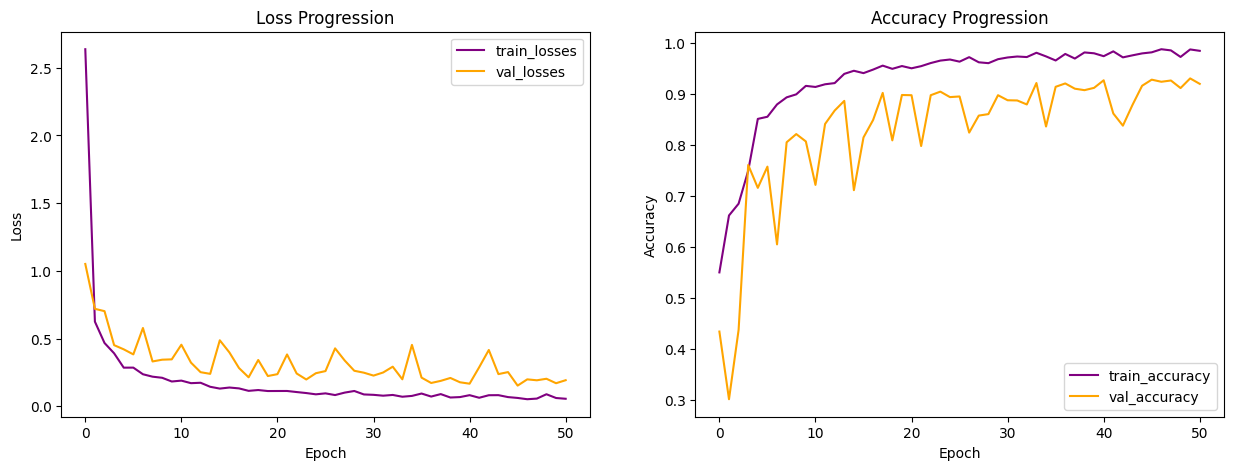

In [62]:
model = build_model(training_audio_features,
                    learning_rate=0.002,
                    gru=256,
                    hidden=[256,128,48],
                    dropout=0.3)

history = model.fit(
   x=training_audio_features,
   y=audio_df['train']['label'],
   sample_weight=training_sample_weights,
   epochs=100,
   validation_data=(
      validation_audio_features,
      audio_df['val']['label'],
      validation_sample_weights
   ),
   batch_size=64,
   callbacks=[callback],
   verbose=1)

best_epoch = history.history['val_weighted_accuracy'].index(max(history.history['val_weighted_accuracy']))+1
print('best_epoch: ', best_epoch)

visualize(history, best_epoch)

In [63]:
train_yhat = model.predict(training_audio_features)

train_yhat_result = np.argmax(train_yhat, axis=-1)

train_results['mfcc_rms_spectral_centroid'] = model.evaluate(training_audio_features,
                                                         audio_df['train']['label'])[-1]

149/149 [==============================] - 1s 7ms/step - loss: 0.0547 - accuracy: 0.9924 - weighted_accuracy: 0.9924


In [64]:
val_yhat = model.predict(validation_audio_features)

val_yhat_result = np.argmax(val_yhat, axis=-1)

val_results['mfcc_rms_spectral_centroid'] = model.evaluate(validation_audio_features,
                                                         audio_df['val']['label'])[-1]

76/76 [==============================] - 1s 7ms/step - loss: 0.2723 - accuracy: 0.9284 - weighted_accuracy: 0.9284


### evaluate the results

In [65]:
print('Training classification Report \n')
print(classification_report(audio_df['train']['label'], train_yhat_result, target_names=classes))

Training classification Report 

              precision    recall  f1-score   support

      barswa       1.00      0.98      0.99      1603
      comsan       0.99      1.00      1.00      1578
     eaywag1       0.99      1.00      0.99      1582

    accuracy                           0.99      4763
   macro avg       0.99      0.99      0.99      4763
weighted avg       0.99      0.99      0.99      4763



In [66]:
print('Validation classification Report \n')
print(classification_report(audio_df['val']['label'], val_yhat_result, target_names=classes))

Validation classification Report 

              precision    recall  f1-score   support

      barswa       0.94      0.91      0.93      1032
      comsan       0.88      0.94      0.91       618
     eaywag1       0.95      0.94      0.95       780

    accuracy                           0.93      2430
   macro avg       0.92      0.93      0.93      2430
weighted avg       0.93      0.93      0.93      2430



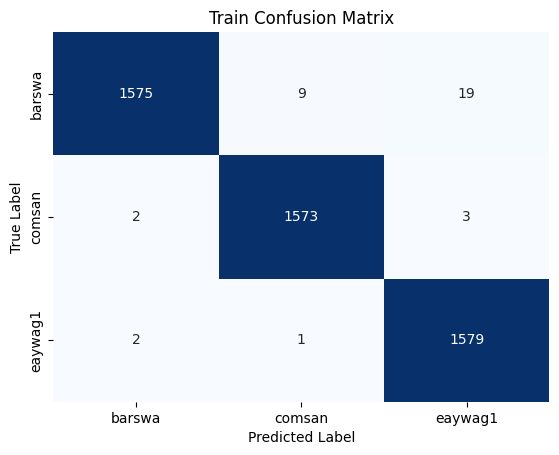

In [67]:
train_cm = tf.math.confusion_matrix(audio_df['train']['label'], train_yhat_result)

ax = sns.heatmap(train_cm,
                 annot=True,
                 fmt='.0f',
                 cmap='Blues',
                 xticklabels=classes,
                 yticklabels=classes,
                 cbar=False)

ax.set(xlabel='Predicted Label', ylabel='True Label')
plt.title('Train Confusion Matrix')
plt.show()

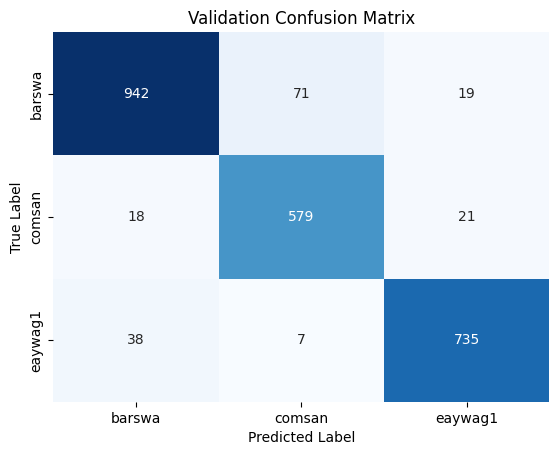

In [68]:
val_cm = tf.math.confusion_matrix(audio_df['val']['label'], val_yhat_result)

ax = sns.heatmap(val_cm,
                 annot=True,
                 fmt='.0f',
                 cmap='Blues',
                 xticklabels=classes,
                 yticklabels=classes,
                 cbar=False)

ax.set(xlabel='Predicted Label', ylabel='True Label')
plt.title('Validation Confusion Matrix')
plt.show()

## With mfcc & rms & chroma & rms & spectral_centroid

### create features

In [69]:
training_audio_features = np.concatenate((audio_df['train']['mfcc'], audio_df['train']['chroma'], audio_df['train']['rms'], audio_df['train']['spectral_centroid']), axis=-1)

training_audio_features

array([[[7.56059408e-01, 7.80727506e-01, 6.08030796e-01, ...,
         7.10010707e-01, 1.26143768e-01, 1.15566564e-01],
        [6.85565889e-01, 7.89295197e-01, 5.32711685e-01, ...,
         6.02864504e-01, 1.40773878e-01, 8.32937834e-02],
        [6.21031046e-01, 7.71719754e-01, 5.21483123e-01, ...,
         4.24081594e-01, 1.50060460e-01, 7.14650109e-02],
        ...,
        [5.67367315e-01, 7.26844251e-01, 6.31003559e-01, ...,
         7.87384212e-01, 1.39405012e-01, 7.56407549e-02],
        [6.20971441e-01, 7.48872697e-01, 6.65857732e-01, ...,
         8.52373362e-01, 1.28030986e-01, 8.96177928e-02],
        [7.05545306e-01, 7.49866128e-01, 6.74731493e-01, ...,
         9.81173992e-01, 1.05921283e-01, 1.20610740e-01]],

       [[8.14119399e-01, 4.40038919e-01, 5.90848446e-01, ...,
         7.14490365e-04, 4.74160254e-01, 6.64023000e-01],
        [7.05331504e-01, 4.33986068e-01, 5.65663338e-01, ...,
         6.81333477e-05, 5.52563906e-01, 6.75583875e-01],
        [4.65061784e-01, 

In [70]:
training_audio_features.shape

(4763, 251, 34)

In [71]:
validation_audio_features = np.concatenate((audio_df['val']['mfcc'], audio_df['val']['chroma'], audio_df['val']['rms'], audio_df['val']['spectral_centroid']), axis=-1)

validation_audio_features

array([[[ 6.07671976e-01,  3.39292169e-01,  1.26388699e-01, ...,
          2.96792746e-01,  1.09754484e-02,  5.15607021e-01],
        [ 5.96676111e-01,  3.43343318e-01,  1.40801817e-01, ...,
          6.74952388e-01,  1.20197879e-02,  4.98173125e-01],
        [ 5.74126482e-01,  3.48844141e-01,  2.11991191e-01, ...,
          2.49027729e-01,  1.32039785e-02,  4.94149287e-01],
        ...,
        [ 5.07300973e-01,  4.28692847e-01,  2.89089710e-01, ...,
          1.00000000e+00,  8.09847936e-03,  4.82302859e-01],
        [ 5.14830351e-01,  4.65034604e-01,  2.36803472e-01, ...,
          9.70978141e-01,  7.86286686e-03,  4.63492619e-01],
        [ 5.31743169e-01,  4.92102832e-01,  2.68609375e-01, ...,
          4.64379847e-01,  6.63630804e-03,  4.35757079e-01]],

       [[ 7.37122238e-01,  9.46214080e-01,  5.00621319e-01, ...,
          9.56980467e-01,  7.73035511e-02,  7.20857847e-02],
        [ 7.35155344e-01,  9.35420394e-01,  4.53360260e-01, ...,
          7.98966825e-01,  8.48300979e

In [72]:
validation_audio_features.shape

(2430, 251, 34)

### fit the model with training data

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 256)               224256    
                                                                 
 batch_normalization (Batch  (None, 256)               1024      
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense (Dense)               (None, 256)               65792     
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                        

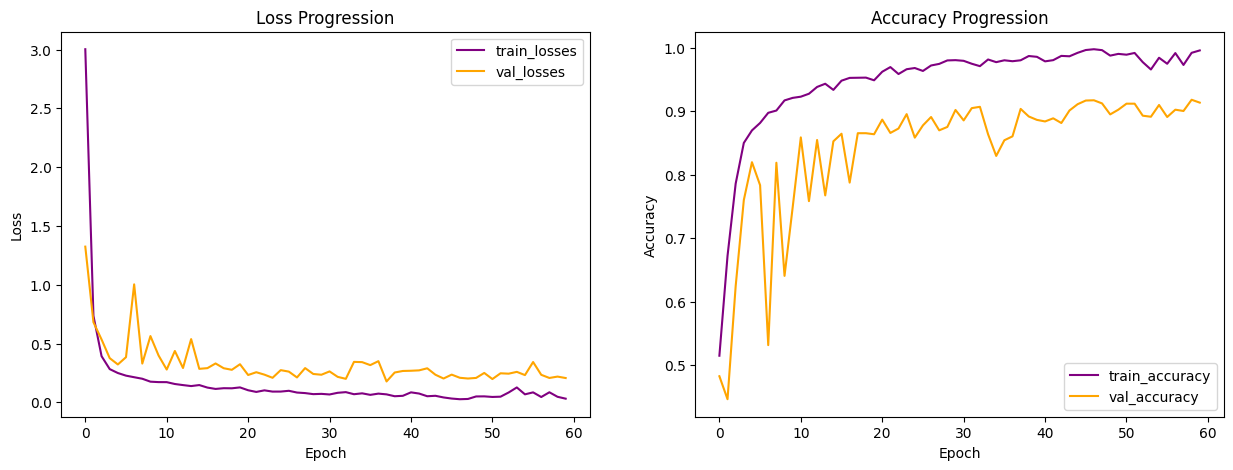

In [73]:
model = build_model(training_audio_features,
                    learning_rate=0.002,
                    gru=256,
                    hidden=[256,128,48],
                    dropout=0.3)

history = model.fit(
   x=training_audio_features,
   y=audio_df['train']['label'],
   sample_weight=training_sample_weights,
   epochs=100,
   validation_data=(
      validation_audio_features,
      audio_df['val']['label'],
      validation_sample_weights
   ),
   batch_size=64,
   callbacks=[callback],
   verbose=1)

best_epoch = history.history['val_weighted_accuracy'].index(max(history.history['val_weighted_accuracy']))+1
print('best_epoch: ', best_epoch)

visualize(history, best_epoch)

In [74]:
train_yhat = model.predict(training_audio_features)

train_yhat_result = np.argmax(train_yhat, axis=-1)

train_results['mfcc_chroma_rms_spectral_centroid'] = model.evaluate(training_audio_features,
                                                         audio_df['train']['label'])[-1]

149/149 [==============================] - 1s 7ms/step - loss: 0.0314 - accuracy: 0.9985 - weighted_accuracy: 0.9985


In [75]:
val_yhat = model.predict(validation_audio_features)

val_yhat_result = np.argmax(val_yhat, axis=-1)

val_results['mfcc_chroma_rms_spectral_centroid'] = model.evaluate(validation_audio_features,
                                                         audio_df['val']['label'])[-1]

76/76 [==============================] - 1s 8ms/step - loss: 0.3939 - accuracy: 0.9181 - weighted_accuracy: 0.9181


### evaluate the results

In [76]:
print('Training classification Report \n')
print(classification_report(audio_df['train']['label'], train_yhat_result, target_names=classes))

Training classification Report 

              precision    recall  f1-score   support

      barswa       1.00      1.00      1.00      1603
      comsan       1.00      1.00      1.00      1578
     eaywag1       1.00      1.00      1.00      1582

    accuracy                           1.00      4763
   macro avg       1.00      1.00      1.00      4763
weighted avg       1.00      1.00      1.00      4763



In [77]:
print('Validation classification Report \n')
print(classification_report(audio_df['val']['label'], val_yhat_result, target_names=classes))

Validation classification Report 

              precision    recall  f1-score   support

      barswa       0.93      0.90      0.92      1032
      comsan       0.87      0.94      0.90       618
     eaywag1       0.94      0.92      0.93       780

    accuracy                           0.92      2430
   macro avg       0.91      0.92      0.92      2430
weighted avg       0.92      0.92      0.92      2430



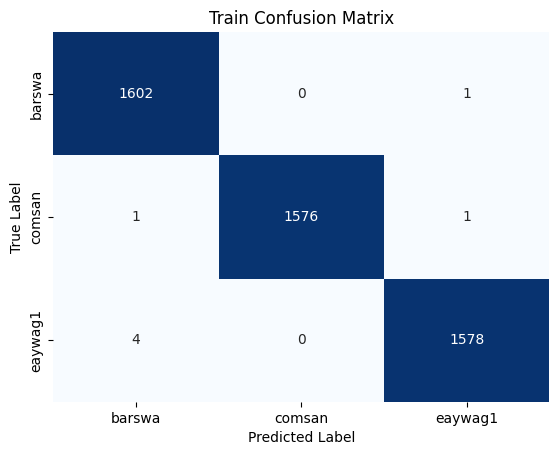

In [78]:
train_cm = tf.math.confusion_matrix(audio_df['train']['label'], train_yhat_result)

ax = sns.heatmap(train_cm,
                 annot=True,
                 fmt='.0f',
                 cmap='Blues',
                 xticklabels=classes,
                 yticklabels=classes,
                 cbar=False)

ax.set(xlabel='Predicted Label', ylabel='True Label')
plt.title('Train Confusion Matrix')
plt.show()

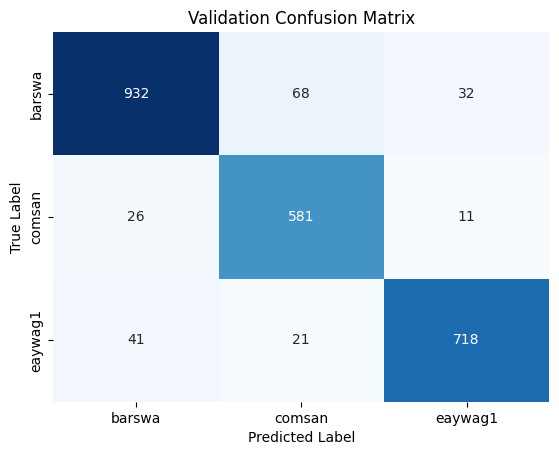

In [79]:
val_cm = tf.math.confusion_matrix(audio_df['val']['label'], val_yhat_result)

ax = sns.heatmap(val_cm,
                 annot=True,
                 fmt='.0f',
                 cmap='Blues',
                 xticklabels=classes,
                 yticklabels=classes,
                 cbar=False)

ax.set(xlabel='Predicted Label', ylabel='True Label')
plt.title('Validation Confusion Matrix')
plt.show()

# Review results from all models

In [80]:
train_results_df = pd.DataFrame(list(train_results.items()), columns=['Features', 'Train_Accuracy']).round(2)
val_results_df = pd.DataFrame(list(val_results.items()), columns=['Features', 'Val_Accuracy']).round(2)

result_df = train_results_df.merge(val_results_df, on='Features')
result_df = result_df.sort_values('Val_Accuracy')
result_df

,Features,Train_Accuracy,Val_Accuracy
2,mfcc_spectral_centroid,0.98,0.91
4,mfcc_chroma_rms_spectral_centroid,1.00,0.92
0,mfcc_chroma,1.00,0.93
1,mfcc_rms,0.99,0.93
3,mfcc_rms_spectral_centroid,0.99,0.93
